In [1]:
import shapefile
from pyproj import Proj, transform
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
from shapely.geometry import Polygon
%matplotlib inline

# data from https://city.milwaukee.gov/DownloadMapData3497.htm
# it is encoded in NAD27 in zone 4803 (Wisconsin South)

In [2]:
# open a single file
#f = open('ald2012.shp', 'rb')
#sf = shapefile.Reader(shp=f)

# load in maps
ald = shapefile.Reader('ald2016/alderman')
nbh = shapefile.Reader('hoods/neighborhood')
pol = shapefile.Reader('poldist/poldist')
ward = shapefile.Reader('wards/ward')
city = shapefile.Reader('corp/citylimit')

In [3]:
# converter for coordinates
inProj = Proj(init='EPSG:32054', preserve_units=True) # NAD27 Wisconsin South
outProj = Proj(proj='latlong', datum='WGS84', ellps='WGS84') # Latitude and Longitude

In [4]:
# read in a geolocated dataset
df = pd.read_csv('../geocoding_data/logged-calls-09-12-18.csv', header=0, index_col='ID', parse_dates=['Date/Time'])
df.head()

Unnamed: 0  Call Number           Date/Time  \
ID                                                                            
182551269-Service in Progress            0    182551269 2018-09-12 12:49:30   
182551267-Service in Progress            1    182551267 2018-09-12 12:48:57   
182551191-Advised/Referral               2    182551191 2018-09-12 12:48:55   
182551256-Service in Progress            3    182551256 2018-09-12 12:48:12   
182551265-Assignment Completed           4    182551265 2018-09-12 12:48:04   

                                                   Location Police District  \
ID                                                                            
182551269-Service in Progress     3626 W FOND DU LAC AV,MKE               7   
182551267-Service in Progress            749 W STATE ST,MKE               1   
182551191-Advised/Referral      7009 W SILVER SPRING DR,MKE               4   
182551256-Service in Progress   N 15TH ST / W HADLEY ST,MKE               5   
182551265-Assignment Completed           5636 N 79TH ST,MKE               4   

                                  Nature of Call                Status  \
ID                                                                       
182551269-Service in Progress         COURT DUTY   Service in Progress   
182551267-Service in Progress     SPECIAL ASSIGN   Service in Progress   
182551191-Advised/Referral           TRBL W/SUBJ      Advised/Referral   
182551256-Service in Progress        TRBL W/SUBJ   Service in Progress   
182551265-Assignment Completed  VACANT HOUSE CHK  Assignment Completed   

                                                 Cleaned_Location  \
ID                                                                  
182551269-Service in Progress     3626 W FOND DU LAC AV,MILWAUKEE   
182551267-Service in Progress            749 W STATE ST,MILWAUKEE   
182551191-Advised/Referral      7009 W SILVER SPRING DR,MILWAUKEE   
182551256-Service in Progress   N 15TH ST & W HADLEY ST,MILWAUKEE   
182551265-Assignment Completed           5636 N 79TH ST,MILWAUKEE   

                                                          Coordinates  \
ID                                                                      
182551269-Service in Progress   {'lat': 43.077239, 'lng': -87.959228}   
182551267-Service in Progress   {'lat': 43.042662, 'lng': -87.920879}   
182551191-Advised/Referral      {'lat': 43.119098, 'lng': -87.999648}   
182551256-Service in Progress   {'lat': 43.069547, 'lng': -87.931272}   
182551265-Assignment Completed  {'lat': 43.120495, 'lng': -88.009319}   

                               Error_Logging  
ID                                            
182551269-Service in Progress            NaN  
182551267-Service in Progress            NaN  
182551191-Advised/Referral               NaN  
182551256-Service in Progress            NaN  
182551265-Assignment Completed           NaN

In [5]:
# parse the latitude and longitude of the coordinates column
split = df['Coordinates'].str.split(',', 1, expand=True)
df['lat'] = split[0].str.replace('{\'lat\': ', '').astype(float)
df['long'] = split[1].str.replace('\'lng\': ', '')
df['long'] = df['long'].str.replace('}', '').astype(float)

In [6]:
# create a new dataframe with just the coordinates
coords = df[['lat', 'long']]
coords = coords.dropna()
coords.head()

lat       long
ID                                                  
182551269-Service in Progress   43.077239 -87.959228
182551267-Service in Progress   43.042662 -87.920879
182551191-Advised/Referral      43.119098 -87.999648
182551256-Service in Progress   43.069547 -87.931272
182551265-Assignment Completed  43.120495 -88.009319

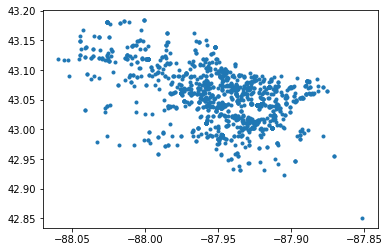

In [7]:
# just plot the points to confirms they're there
plt.plot(coords['long'], coords['lat'], '.')

In [8]:
def plotOn(sf, coords, sfName, drawMap=False):
    # initialize plot size
    plt.figure(figsize=(10,18)) # approx dimensions of MKE is 5:9
    if not drawMap:
        # limit bounds of the plot
        plt.xlim(-88.1,-87.85)
        plt.ylim(42.9,43.2)
        m = plt
    else:
        # attempt to draw a map, it's not working
        m = Basemap(llcrnrlon=-88.1, llcrnrlat=42.9, urcrnrlon=-87.85, urcrnrlat=43.2, 
                    lon_0=(-88.1 + -87.85)/2, lat_0=(42.9 + 43.2)/2, 
                    resolution='i', projection='tmerc')
        m.drawcoastlines()
        m.drawrivers()
        m.drawmapboundary()
        m.fillcontinents(color='#ddaa66',lake_color='aqua')

    # loop through shapes
    polys = []
    for i,shape in enumerate(sf.shapes()):
        xs = []
        ys = []
        points = []

        # loop through points
        for point in shape.points:
            # parse points
            coord = [float('%.3f' % coord) for coord in point]
            # convert points
            x, y = transform(inProj, outProj, coord[0], coord[1])
            # add to list
            xs.append(x)
            ys.append(y)
            points.append((x, y))
            
        # make a polygon out of the points
        poly = Polygon(points)
        polys.append(poly)
        
        # find the district, ward, etc that a point is in
        for index, row in coords.iterrows():
            point = Point(row['long'], row['lat'])
            if poly.contains(point):
                coords.loc[index, sfName] = i

        # plot shape
        m.plot(xs, ys, '-')

    #for index, row in coords.iterrows():
    m.plot(coords['long'], coords['lat'], '.')

    plt.show()
    return polys

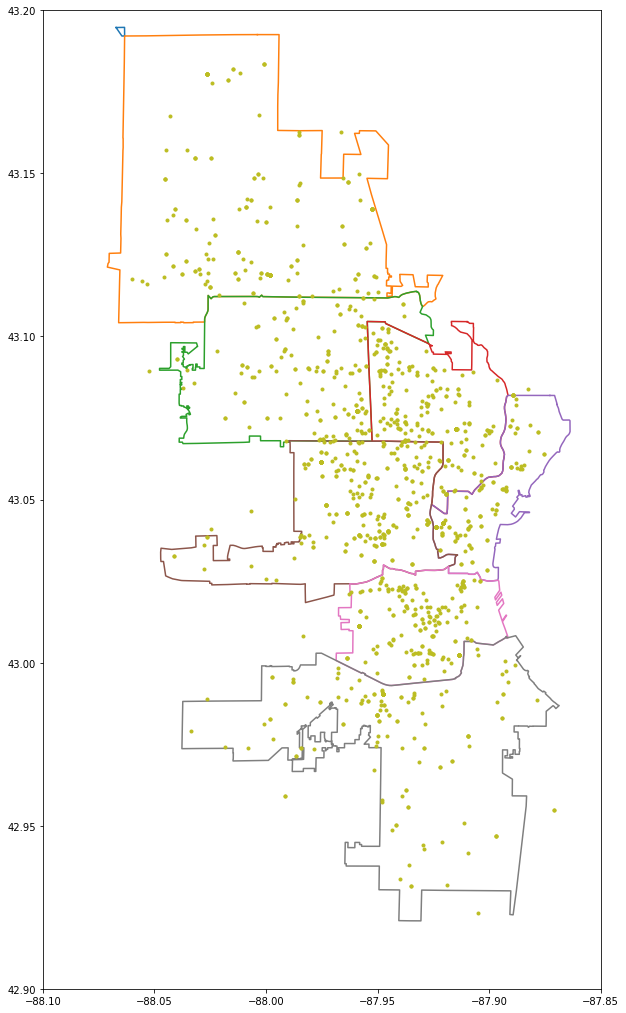

In [9]:
polys = plotOn(pol, coords, 'police district')

In [10]:
coords.head()

lat       long  police district
ID                                                                   
182551269-Service in Progress   43.077239 -87.959228              2.0
182551267-Service in Progress   43.042662 -87.920879              4.0
182551191-Advised/Referral      43.119098 -87.999648              1.0
182551256-Service in Progress   43.069547 -87.931272              3.0
182551265-Assignment Completed  43.120495 -88.009319              1.0